# Mini-Projeto: Reconhecimento de Dígitos Manuscritos com CNN

## Integrantes do Grupo

- Maurício Sightman
- Paula
- Daniel
- Pedro

## Descrição do Projeto

Este projeto tem como objetivo aprender os conceitos básicos da arquitetura de Redes Neurais Convolucionais (CNN) utilizando o Google Colab. Para isso, usaremos o conjunto de dados MNIST, que é amplamente utilizado para o reconhecimento de dígitos manuscritos. Através deste mini-projeto, esperamos compreender melhor como as CNNs funcionam e como podem ser aplicadas para resolver problemas de classificação de imagens.

## Estrutura do Projeto

1. **Importação de Bibliotecas**: Importar todas as bibliotecas necessárias para o projeto, como TensorFlow, Keras, NumPy, Matplotlib, entre outras.
2. **Carregamento e Pré-processamento dos Dados**: Carregar o conjunto de dados MNIST e realizar o pré-processamento necessário.
3. **Construção, treinamento e avaliação de diferentes modelos de Redes Neurais**: Evolução da arquitetura de redes neurais utilizando CNN.
4. **Gridsearch**: Treinamento usando técnica de gridsearch.
5. **Comparativos**: Comparação dos diferentes modelos.


In [335]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import ParameterGrid
import pandas as pd
import time
import random

In [336]:
RANDOM_SEED = 33
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [255]:
results = []

### **Carregamento e Pré-processamento dos Dados**


In [337]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

full_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size])

In [338]:
batch_size = 10

In [339]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [340]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

48000 12000 10000


In [341]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

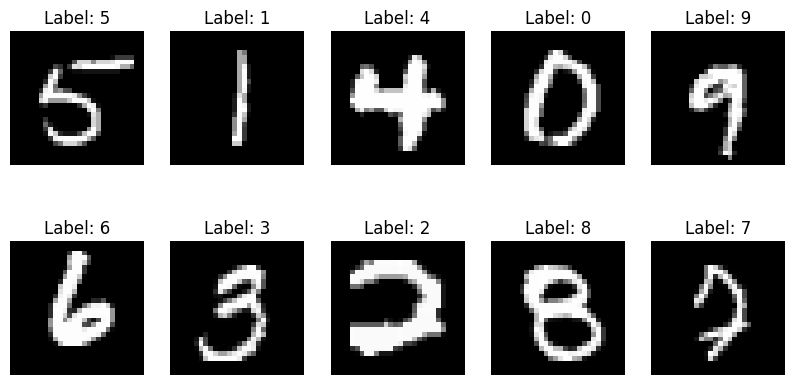

In [342]:
label_to_image = {}

for image, label in train_dataset:
    if label not in label_to_image:
        label_to_image[label] = image

plt.figure(figsize=(10, 5))
for i, (label, image) in enumerate(label_to_image.items()):
    plt.subplot(2, 5, i + 1)
    plt.title(f'Label: {label}')
    plt.imshow(image.squeeze().numpy(), cmap='gray')
    plt.axis('off')

plt.show()

### Functions


In [343]:
use_cuda = torch.cuda.is_available()
if use_cuda:
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [344]:
# Implementação do Early Stopping
class EarlyStopping:
  def __init__(self, patience=7, delta=0, verbose=True, path='checkpoint.pt'):
      self.patience = patience
      self.delta = delta
      self.verbose = verbose
      self.counter = 0
      self.early_stop = False
      self.val_min_loss = np.Inf
      self.path = path

  def __call__(self, val_loss, model):
    if val_loss < self.val_min_loss - self.delta:   # Caso a loss da validação reduza, vamos salvar o modelo e nova loss mínima
      self.save_checkpoint(val_loss, model)
      self.counter = 0
    else:                                           # Caso a loss da validação NÃO reduza, vamos incrementar o contador da paciencia
      self.counter += 1
      print(f'EarlyStopping counter: {self.counter} out of {self.patience}. Current validation loss: {val_loss:.5f}')
      if self.counter >= self.patience:
          self.early_stop = True

  def save_checkpoint(self, val_loss, model):
    if self.verbose:
        print(f'Validation loss decreased ({self.val_min_loss:.5f} --> {val_loss:.5f}).  Saving model ...')
    torch.save(model, self.path)
    self.val_min_loss = val_loss

In [345]:
# Curva de perda vs validação
def plot_train_val_losses(train_avg_losses, val_avg_losses):
  epochs = list(range(1, len(train_avg_losses)+1))
  plt.plot(epochs, train_avg_losses, color='blue', label='Loss do treino')
  plt.plot(epochs, val_avg_losses, color='orange', label='Loss da validação')
  plt.title('Losses de treino e validação por época de treinamento')
  plt.legend()

In [346]:
# Acurácia por label
def plot_accuracy_per_label(y_true, y_pred, output_size=10):
    cm = confusion_matrix(y_true, y_pred)
    class_accuracies = cm.diagonal() / cm.sum(axis=1)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(output_size), yticklabels=range(output_size))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

In [347]:
# Metrícas do conjunto de teste
def test_and_get_metrics(model, test_loader, device='cpu'):
    model.eval()
    model.to(device)

    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            test_loss += loss.item()
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    test_loss /= len(test_loader.dataset)

    y_pred = np.array(all_preds).squeeze()
    y_true = np.array(all_targets)

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    tpr = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    return {
        'acc':acc,
        'tpr':tpr,
        'precision':precision,
        'f1-score':f1,
        'y_true':y_true,
        'y_pred':y_pred,
        'loss':test_loss,
    }

In [348]:
# Expande o data fazendo transformações
def expand_mnist_dataset(train_dataset):
    expanded_training_pairs = []
    print("Expanding the MNIST training set")
    
    for i in range(len(train_dataset)):
        image, label = train_dataset[i]
        image = image.numpy().squeeze()
        expanded_training_pairs.append((image.flatten(), label))
        
        for d, axis, index_position, index in [
            (1, 0, "first", 0),
            (-1, 0, "first", 27),
            (1, 1, "last", 0),
            (-1, 1, "last", 27)
        ]:
            new_img = np.roll(image, d, axis)
            if index_position == "first":
                new_img[index, :] = np.zeros(28)
            else:
                new_img[:, index] = np.zeros(28)
            expanded_training_pairs.append((new_img.flatten(), label))

    random.shuffle(expanded_training_pairs)
    expanded_images, expanded_labels = zip(*expanded_training_pairs)
    expanded_images = np.array(expanded_images)
    expanded_labels = np.array(expanded_labels)

    return expanded_images, expanded_labels

In [15]:
class ExpandedMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape(28, 28).astype(np.float32)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

### MLP (Sigmoid)


In [349]:
class SingleHiddenLayerNN(nn.Module):
    def __init__(self, in_features, dropout_rate=0.):
        super(SingleHiddenLayerNN, self).__init__()
        self.early_stopping = None
        self.net = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features, 100),
          nn.Sigmoid(),
          nn.Dropout(dropout_rate),
          nn.Linear(100, 10),
        )

    def forward(self, x):
        output = self.net(x)
        output = nn.functional.log_softmax(output, dim=1)
        return output

    def compile(self, learning_rate, weight_decay=0.0):
      self.optimizer = optim.SGD(self.parameters(), weight_decay=weight_decay, lr=learning_rate)
      self.criterion = nn.NLLLoss()

    def fit(self, train_loader, num_epochs, val_loader = None, patience = None, delta = None):
      if val_loader is not None and patience is not None and delta is not None:
        print(f'Using early stopping with patience={patience} and delta={delta}')
        self.early_stopping = EarlyStopping(patience, delta)

      val_avg_losses = []
      train_avg_losses = []
      start_time = time.time()

      for epoch in range(num_epochs):
        # Calibrando os pesos do modelo
        train_losses = []
        self.train()
        for batch_idx, (X, y) in enumerate(train_loader):
          X, y = X.to(device), y.to(device)
          output = self.forward(X)

          train_loss = self.criterion(output, y)
          self.optimizer.zero_grad()
          train_loss.backward()
          self.optimizer.step()
          train_losses.append(train_loss.item())
        train_avg_loss = np.mean(train_losses)
        train_avg_losses.append(train_avg_loss)
        print(f'Epoch#{epoch+1}: Train Average Loss = {train_avg_loss:.5f}')

        # Mecanismo de early stopping
        if self.early_stopping is not None:
          val_losses = []
          self.eval()
          with torch.no_grad():
            for batch_idx, (X, y) in enumerate(val_loader):
              X, y = X.to(device), y.to(device)
              output = self.forward(X)
              val_loss = self.criterion(output, y)
              val_losses.append(val_loss.item())
          val_avg_loss = np.mean(val_losses)
          val_avg_losses.append(val_avg_loss)
          self.early_stopping(val_avg_loss, self)
          if self.early_stopping.early_stop:
            print(f'Stopped by early stopping at epoch {epoch+1}')
            break

      if self.early_stopping is not None:
        self = torch.load('checkpoint.pt')
      self.eval()

      end_time = time.time()
      training_time = end_time - start_time
      return train_avg_losses, val_avg_losses, training_time


    def test(self, test_loader):
      test_losses = []
      test_loss = 0
      correct = 0
      with torch.no_grad():
        for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = self.forward(data)
          test_loss += F.nll_loss(output, target, size_average=False).item()
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).sum()
      test_loss /= len(test_loader.dataset)
      test_losses.append(test_loss)
      acc = 100. * correct / len(test_loader.dataset)
      print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        acc))
      return test_loss, acc, test_losses

In [350]:
input_size = train_dataset[0][0].shape[1] * train_dataset[0][0].shape[2]
learning_rate = 0.03
weight_decay = 0.1
dropout_rate = 0.
num_epochs = 60
patience = 10
delta = 0.001

In [351]:
mlp = SingleHiddenLayerNN(input_size)
mlp.compile(learning_rate = learning_rate)

In [352]:
mlp_train_avg_losses, mlp_val_avg_losses, mlp_training_time = mlp.fit(train_loader, num_epochs, val_loader, patience, delta)

Using early stopping with patience=10 and delta=0.001
Epoch#1: Train Average Loss = 0.53665
Validation loss decreased (inf --> 0.30523).  Saving model ...
Epoch#2: Train Average Loss = 0.27761
Validation loss decreased (0.30523 --> 0.24590).  Saving model ...
Epoch#3: Train Average Loss = 0.22345
Validation loss decreased (0.24590 --> 0.22448).  Saving model ...
Epoch#4: Train Average Loss = 0.18852
Validation loss decreased (0.22448 --> 0.18580).  Saving model ...
Epoch#5: Train Average Loss = 0.16133
Validation loss decreased (0.18580 --> 0.17058).  Saving model ...
Epoch#6: Train Average Loss = 0.14199
Validation loss decreased (0.17058 --> 0.14918).  Saving model ...
Epoch#7: Train Average Loss = 0.12650
Validation loss decreased (0.14918 --> 0.13293).  Saving model ...
Epoch#8: Train Average Loss = 0.11452
Validation loss decreased (0.13293 --> 0.12776).  Saving model ...
Epoch#9: Train Average Loss = 0.10460
Validation loss decreased (0.12776 --> 0.12325).  Saving model ...
Epoch

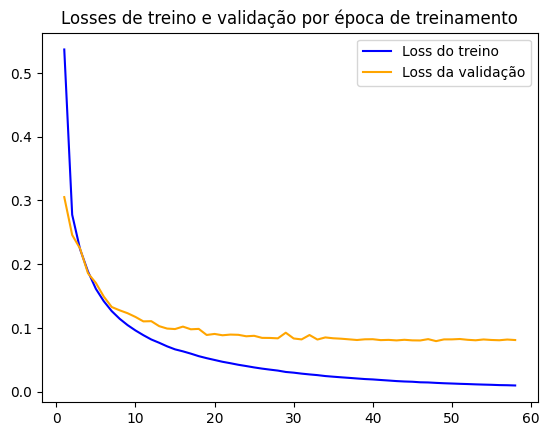

In [353]:
plot_train_val_losses(mlp_train_avg_losses, mlp_val_avg_losses)

In [354]:
mlp.test(test_loader)

/Users/mauriciosightman/Library/Python/3.9/lib/python/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0719, Accuracy: 9784/10000 (97.84%)



(0.07185851127314673, tensor(97.8400), [0.07185851127314673])

In [355]:
mlp_model_metrics = test_and_get_metrics(mlp, test_loader, device)

results.append({
    'model': 'mlp_model',
    'train_avg_losses': mlp_train_avg_losses,
    'val_avg_losses': mlp_val_avg_losses,
    'training_time': mlp_training_time,
    'learning_rate': learning_rate,
    'dropout_rate': dropout_rate,
    'acc':mlp_model_metrics['acc'],
    'tpr':mlp_model_metrics['tpr'],
    'precision':mlp_model_metrics['precision'],
    'f1-score':mlp_model_metrics['f1-score'],
    'y_true':mlp_model_metrics['y_true'],
    'y_pred':mlp_model_metrics['y_pred'],
    'loss':mlp_model_metrics['loss'],
})

mlp_model_metrics

{'acc': 0.9784,
 'tpr': 0.9784,
 'precision': 0.9784110837862092,
 'f1-score': 0.9783974054160656,
 'y_true': array([7, 2, 1, ..., 4, 5, 6]),
 'y_pred': array([7, 2, 1, ..., 4, 5, 6]),
 'loss': 0.0071858511173191805}

### CNN 1 (Sigmoid)


In [356]:
class OneConvNN(nn.Module):
    def __init__(self, in_features, dropout_rate=0.):
        super(OneConvNN, self).__init__()
        self.early_stopping = True
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.net = nn.Sequential(
          nn.Linear(20*12*12, 100),
          nn.Sigmoid(),
          nn.Dropout(dropout_rate),
          nn.Linear(100, 10),
        )

    def forward(self, x):
        x = F.sigmoid(self.pool(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = self.net(x)
        x = nn.functional.log_softmax(x, dim=1)
        return x

    def compile(self, learning_rate, weight_decay=0.0):
      self.optimizer = optim.SGD(self.parameters(), weight_decay=weight_decay, lr=learning_rate)
      self.criterion = nn.NLLLoss()

    def fit(self, train_loader, num_epochs, val_loader = None, patience = None, delta = None):
      if val_loader is not None and patience is not None and delta is not None:
        print(f'Using early stopping with patience={patience} and delta={delta}')
        self.early_stopping = EarlyStopping(patience, delta)

      val_avg_losses = []
      train_avg_losses = []
      start_time = time.time()

      for epoch in range(num_epochs):
        # Calibrando os pesos do modelo
        train_losses = []
        self.train()
        for batch_idx, (X, y) in enumerate(train_loader):
          X, y = X.to(device), y.to(device)
          output = self.forward(X)

          train_loss = self.criterion(output, y) 
          self.optimizer.zero_grad()
          train_loss.backward()
          self.optimizer.step()
          train_losses.append(train_loss.item())
        train_avg_loss = np.mean(train_losses)
        train_avg_losses.append(train_avg_loss)
        print(f'Epoch#{epoch+1}: Train Average Loss = {train_avg_loss:.5f}')

        # Mecanismo de early stopping
        if self.early_stopping is not None:
          val_losses = []
          self.eval()
          with torch.no_grad():
            for batch_idx, (X, y) in enumerate(val_loader):
              X, y = X.to(device), y.to(device)
              output = self.forward(X)
              val_loss = self.criterion(output, y)
              val_losses.append(val_loss.item())
          val_avg_loss = np.mean(val_losses)
          val_avg_losses.append(val_avg_loss)
          self.early_stopping(val_avg_loss, self)
          if self.early_stopping.early_stop:
            print(f'Stopped by early stopping at epoch {epoch+1}')
            break

      if self.early_stopping is not None:
        self = torch.load('checkpoint.pt')
      self.eval()

      end_time = time.time()
      training_time = end_time - start_time
      return train_avg_losses, val_avg_losses, training_time


    def test(self, test_loader):
      test_losses = []
      test_loss = 0
      correct = 0
      with torch.no_grad():
        for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = self.forward(data)
          test_loss += F.nll_loss(output, target, size_average=False).item()
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).sum()
      test_loss /= len(test_loader.dataset)
      test_losses.append(test_loss)
      acc = 100. * correct / len(test_loader.dataset)
      print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        acc))
      return test_loss, acc, test_losses


In [357]:
input_size = train_dataset[0][0].shape[1] * train_dataset[0][0].shape[2]
learning_rate = 0.03
weight_decay = 0.1
dropout_rate = 0.
num_epochs = 60
patience = 10
delta = 0.001

In [358]:
model_ccn_1 = OneConvNN(input_size).to(device)
model_ccn_1.compile(learning_rate = learning_rate)

In [360]:
cnn_1_train_avg_losses, cnn_1_val_avg_losses, cnn_1_training_time = model_ccn_1.fit(train_loader, num_epochs, val_loader, patience, delta)

Using early stopping with patience=5 and delta=0.001
Epoch#1: Train Average Loss = 0.13407
Validation loss decreased (inf --> 0.12184).  Saving model ...
Epoch#2: Train Average Loss = 0.11034
Validation loss decreased (0.12184 --> 0.10504).  Saving model ...
Epoch#3: Train Average Loss = 0.09300
Validation loss decreased (0.10504 --> 0.09342).  Saving model ...
Epoch#4: Train Average Loss = 0.08013
Validation loss decreased (0.09342 --> 0.08539).  Saving model ...
Epoch#5: Train Average Loss = 0.06995
Validation loss decreased (0.08539 --> 0.07715).  Saving model ...
Epoch#6: Train Average Loss = 0.06173
Validation loss decreased (0.07715 --> 0.07250).  Saving model ...
Epoch#7: Train Average Loss = 0.05521
Validation loss decreased (0.07250 --> 0.06885).  Saving model ...
Epoch#8: Train Average Loss = 0.05039
Validation loss decreased (0.06885 --> 0.06706).  Saving model ...
Epoch#9: Train Average Loss = 0.04569
Validation loss decreased (0.06706 --> 0.06219).  Saving model ...
Epoch#

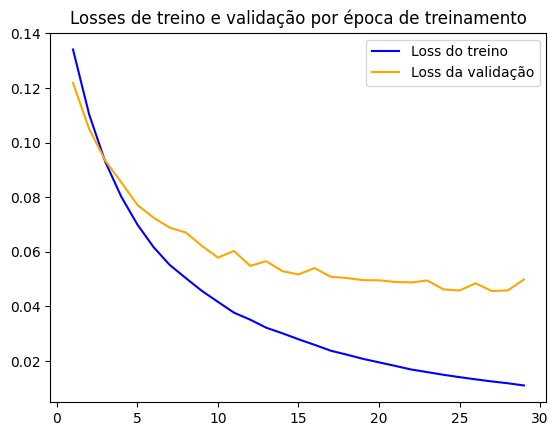

In [361]:
plot_train_val_losses(cnn_1_train_avg_losses, cnn_1_val_avg_losses)

In [362]:
model_ccn_1.test(test_loader)

/Users/mauriciosightman/Library/Python/3.9/lib/python/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0413, Accuracy: 9865/10000 (98.65%)



(0.041255567591424916, tensor(98.6500), [0.041255567591424916])

In [363]:
cnn_1_model_metrics = test_and_get_metrics(model_ccn_1, test_loader, device)

results.append({
    'model': 'model_ccn_1',
    'train_avg_losses': cnn_1_train_avg_losses,
    'val_avg_losses': cnn_1_val_avg_losses,
    'training_time': cnn_1_training_time,
    'learning_rate': learning_rate,
    'dropout_rate': dropout_rate,
    'acc':cnn_1_model_metrics['acc'],
    'tpr':cnn_1_model_metrics['tpr'],
    'precision':cnn_1_model_metrics['precision'],
    'f1-score':cnn_1_model_metrics['f1-score'],
    'y_true':cnn_1_model_metrics['y_true'],
    'y_pred':cnn_1_model_metrics['y_pred'],
    'loss':cnn_1_model_metrics['loss'],
})

cnn_1_model_metrics

{'acc': 0.9865,
 'tpr': 0.9865,
 'precision': 0.9865504832661501,
 'f1-score': 0.9865019667977254,
 'y_true': array([7, 2, 1, ..., 4, 5, 6]),
 'y_pred': array([7, 2, 1, ..., 4, 5, 6]),
 'loss': 0.004125556768645947}

Ao adicionar uma camada de convolução ao modelo, a acurácia aumentou em 0,81 pontos percentuais. Esse aumento representa uma melhoria significativa no desempenho do modelo.

### CNN 2 (Sigmoid)


In [364]:
# Define the neural network architecture
class TwoConvNN(nn.Module):
    def __init__(self, in_features, dropout_rate=0.):
        super(TwoConvNN, self).__init__()
        self.early_stopping = True
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=40, kernel_size=5, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.net = nn.Sequential(
          nn.Linear(40*4*4, 100),
          nn.Sigmoid(),
          nn.Dropout(dropout_rate),
          nn.Linear(100, 10),
        )

    def forward(self, x):
        x = F.sigmoid(self.pool1(self.conv1(x)))
        x = F.sigmoid(self.pool2(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.net(x)
        x = nn.functional.log_softmax(x, dim=1)
        return x

    def compile(self, learning_rate, weight_decay=0.0):
      self.optimizer = optim.SGD(self.parameters(), weight_decay=weight_decay, lr=learning_rate)
      self.criterion = nn.NLLLoss()

    def fit(self, train_loader, num_epochs, val_loader = None, patience = None, delta = None):
      if val_loader is not None and patience is not None and delta is not None:
        print(f'Using early stopping with patience={patience} and delta={delta}')
        self.early_stopping = EarlyStopping(patience, delta)

      val_avg_losses = []
      train_avg_losses = []
      start_time = time.time()

      for epoch in range(num_epochs):
        # Calibrando os pesos do modelo
        train_losses = []
        self.train()
        for batch_idx, (X, y) in enumerate(train_loader):
          X, y = X.to(device), y.to(device)  # Move data to device
          output = self.forward(X)

          train_loss = self.criterion(output, y)  # Use defined criterion
          self.optimizer.zero_grad()
          train_loss.backward()
          self.optimizer.step()
          train_losses.append(train_loss.item())
        train_avg_loss = np.mean(train_losses)
        train_avg_losses.append(train_avg_loss)
        print(f'Epoch#{epoch+1}: Train Average Loss = {train_avg_loss:.5f}')

        # Mecanismo de early stopping
        if self.early_stopping is not None:
          val_losses = []
          self.eval()
          with torch.no_grad():
            for batch_idx, (X, y) in enumerate(val_loader):
              X, y = X.to(device), y.to(device)  # Move data to device
              output = self.forward(X)
              val_loss = self.criterion(output, y)
              val_losses.append(val_loss.item())
          val_avg_loss = np.mean(val_losses)
          val_avg_losses.append(val_avg_loss)
          self.early_stopping(val_avg_loss, self)
          if self.early_stopping.early_stop:
            print(f'Stopped by early stopping at epoch {epoch+1}')
            break

      if self.early_stopping is not None:
        self = torch.load('checkpoint.pt')
      self.eval()

      end_time = time.time()
      training_time = end_time - start_time
      return train_avg_losses, val_avg_losses, training_time


    def test(self, test_loader):
      test_losses = []
      test_loss = 0
      correct = 0
      with torch.no_grad():
        for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = self.forward(data)
          test_loss += F.nll_loss(output, target, size_average=False).item()
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).sum()
      test_loss /= len(test_loader.dataset)
      test_losses.append(test_loss)
      acc = 100. * correct / len(test_loader.dataset)
      print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        acc))
      return test_loss, acc, test_losses

In [365]:
input_size = train_dataset[0][0].shape[1] * train_dataset[0][0].shape[2]
learning_rate = 0.03
weight_decay = 0.1
dropout_rate = 0.
num_epochs = 60
patience = 5
delta = 0.001

In [367]:
# Create an instance of the neural network
model_ccn_2 = TwoConvNN(input_size).to(device)
model_ccn_2.compile(learning_rate = learning_rate)

In [368]:
ccn_2_train_avg_losses_2, ccn_2_val_avg_losses_2, ccn_2_training_time = model_ccn_2.fit(train_loader, num_epochs, val_loader, patience, delta)

Using early stopping with patience=5 and delta=0.001
Epoch#1: Train Average Loss = 1.96116
Validation loss decreased (inf --> 0.63770).  Saving model ...
Epoch#2: Train Average Loss = 0.34931
Validation loss decreased (0.63770 --> 0.21322).  Saving model ...
Epoch#3: Train Average Loss = 0.17703
Validation loss decreased (0.21322 --> 0.14386).  Saving model ...
Epoch#4: Train Average Loss = 0.12735
Validation loss decreased (0.14386 --> 0.11170).  Saving model ...
Epoch#5: Train Average Loss = 0.10234
Validation loss decreased (0.11170 --> 0.10020).  Saving model ...
Epoch#6: Train Average Loss = 0.08782
Validation loss decreased (0.10020 --> 0.08592).  Saving model ...
Epoch#7: Train Average Loss = 0.07628
Validation loss decreased (0.08592 --> 0.07492).  Saving model ...
Epoch#8: Train Average Loss = 0.06858
Validation loss decreased (0.07492 --> 0.06888).  Saving model ...
Epoch#9: Train Average Loss = 0.06228
Validation loss decreased (0.06888 --> 0.06336).  Saving model ...
Epoch#

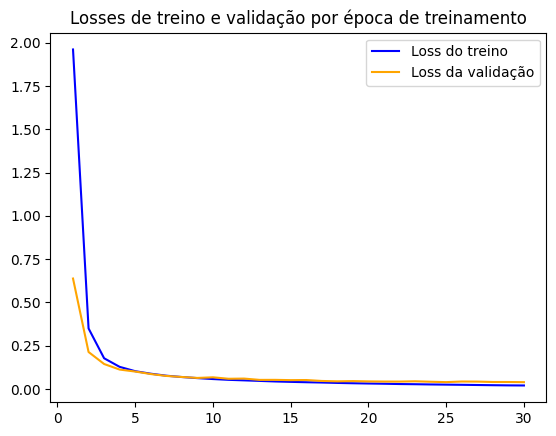

In [369]:
plot_train_val_losses(ccn_2_train_avg_losses_2, ccn_2_val_avg_losses_2)

In [370]:
model_ccn_2.test(test_loader)

/Users/mauriciosightman/Library/Python/3.9/lib/python/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0303, Accuracy: 9890/10000 (98.90%)



(0.030272847305380855, tensor(98.9000), [0.030272847305380855])

In [371]:
ccn_2_model_metrics = test_and_get_metrics(model_ccn_2, test_loader, device)

results.append({
    'model': 'model_ccn_2',
    'train_avg_losses': ccn_2_train_avg_losses_2,
    'val_avg_losses': ccn_2_val_avg_losses_2,
    'training_time': ccn_2_training_time,
    'learning_rate': learning_rate,
    'dropout_rate': dropout_rate,
    'acc':ccn_2_model_metrics['acc'],
    'tpr':ccn_2_model_metrics['tpr'],
    'precision':ccn_2_model_metrics['precision'],
    'f1-score':ccn_2_model_metrics['f1-score'],
    'y_true':ccn_2_model_metrics['y_true'],
    'y_pred':ccn_2_model_metrics['y_pred'],
    'loss':ccn_2_model_metrics['loss'],
})

ccn_2_model_metrics

{'acc': 0.989,
 'tpr': 0.989,
 'precision': 0.9890295886794369,
 'f1-score': 0.9889989760924908,
 'y_true': array([7, 2, 1, ..., 4, 5, 6]),
 'y_pred': array([7, 2, 1, ..., 4, 5, 6]),
 'loss': 0.0030272847373173134}

In [372]:
ccn_2_training_time

720.1132550239563

Ao adicionar uma segunda camada de convolução, a acurácia aumentou em 0,29 pontos percentuais. Embora esse aumento seja menor em comparação com a adição da primeira camada, ele ainda indica uma melhora no desempenho do modelo, sugerindo que camadas adicionais de convolução continuam a refinar a capacidade de extração de características relevantes, embora com ganhos incrementais menores. No entanto, é importante notar que essa melhoria na acurácia veio acompanhada de um aumento de 10 minutos no tempo de treinamento, destacando um trade-off entre a precisão e a eficiência do modelo.

### CNN 2 (Tanh)


In [374]:
# Define the neural network architecture
class TwoConvNNWithTanh(nn.Module):
    def __init__(self, in_features, dropout_rate=0.):
        super(TwoConvNNWithTanh, self).__init__()
        self.early_stopping = True
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=40, kernel_size=5, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.net = nn.Sequential(
          nn.Linear(40*4*4, 100),
          nn.Tanh(),
          nn.Dropout(dropout_rate),
          nn.Linear(100, 10),
        )

    def forward(self, x):
        x = F.tanh(self.pool1(self.conv1(x)))
        x = F.tanh(self.pool2(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.net(x)
        x = nn.functional.log_softmax(x, dim=1)
        return x

    def compile(self, learning_rate, weight_decay=0.0):
      self.optimizer = optim.SGD(self.parameters(), weight_decay=weight_decay, lr=learning_rate)
      self.criterion = nn.NLLLoss()

    def fit(self, train_loader, num_epochs, val_loader = None, patience = None, delta = None):
      if val_loader is not None and patience is not None and delta is not None:
        print(f'Using early stopping with patience={patience} and delta={delta}')
        self.early_stopping = EarlyStopping(patience, delta)

      val_avg_losses = []
      train_avg_losses = []
      start_time = time.time()

      for epoch in range(num_epochs):
        # Calibrando os pesos do modelo
        train_losses = []
        self.train()
        for batch_idx, (X, y) in enumerate(train_loader):
          X, y = X.to(device), y.to(device)  # Move data to device
          output = self.forward(X)

          train_loss = self.criterion(output, y)  # Use defined criterion
          self.optimizer.zero_grad()
          train_loss.backward()
          self.optimizer.step()
          train_losses.append(train_loss.item())
        train_avg_loss = np.mean(train_losses)
        train_avg_losses.append(train_avg_loss)
        print(f'Epoch#{epoch+1}: Train Average Loss = {train_avg_loss:.5f}')

        # Mecanismo de early stopping
        if self.early_stopping is not None:
          val_losses = []
          self.eval()
          with torch.no_grad():
            for batch_idx, (X, y) in enumerate(val_loader):
              X, y = X.to(device), y.to(device)  # Move data to device
              output = self.forward(X)
              val_loss = self.criterion(output, y)
              val_losses.append(val_loss.item())
          val_avg_loss = np.mean(val_losses)
          val_avg_losses.append(val_avg_loss)
          self.early_stopping(val_avg_loss, self)
          if self.early_stopping.early_stop:
            print(f'Stopped by early stopping at epoch {epoch+1}')
            break

      if self.early_stopping is not None:
        self = torch.load('checkpoint.pt')
      self.eval()

      end_time = time.time()
      training_time = end_time - start_time
      return train_avg_losses, val_avg_losses, training_time


    def test(self, test_loader):
      test_losses = []
      test_loss = 0
      correct = 0
      with torch.no_grad():
        for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = self.forward(data)
          test_loss += F.nll_loss(output, target, size_average=False).item()
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).sum()
      test_loss /= len(test_loader.dataset)
      test_losses.append(test_loss)
      acc = 100. * correct / len(test_loader.dataset)
      print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        acc))
      return test_loss, acc, test_losses

In [375]:
input_size = train_dataset[0][0].shape[1] * train_dataset[0][0].shape[2]
learning_rate = 0.03
weight_decay = 0.1
dropout_rate = 0.
num_epochs = 60
patience = 5
delta = 0.001

In [376]:
# Create an instance of the neural network
model_ccn_2_tanh = TwoConvNNWithTanh(input_size).to(device)
model_ccn_2_tanh.compile(learning_rate = learning_rate)

In [377]:
tanh_train_avg_losses, tanh_val_avg_losses, tanh_training_time = model_ccn_2_tanh.fit(train_loader, num_epochs, val_loader, patience, delta)

Using early stopping with patience=5 and delta=0.001
Epoch#1: Train Average Loss = 0.17912
Validation loss decreased (inf --> 0.06220).  Saving model ...
Epoch#2: Train Average Loss = 0.05261
Validation loss decreased (0.06220 --> 0.05020).  Saving model ...
Epoch#3: Train Average Loss = 0.03588
Validation loss decreased (0.05020 --> 0.04337).  Saving model ...
Epoch#4: Train Average Loss = 0.02449
Validation loss decreased (0.04337 --> 0.04167).  Saving model ...
Epoch#5: Train Average Loss = 0.01809
Validation loss decreased (0.04167 --> 0.03710).  Saving model ...
Epoch#6: Train Average Loss = 0.01265
EarlyStopping counter: 1 out of 5. Current validation loss: 0.03861
Epoch#7: Train Average Loss = 0.00916
Validation loss decreased (0.03710 --> 0.03600).  Saving model ...
Epoch#8: Train Average Loss = 0.00684
Validation loss decreased (0.03600 --> 0.03385).  Saving model ...
Epoch#9: Train Average Loss = 0.00472
EarlyStopping counter: 1 out of 5. Current validation loss: 0.03527
Epoc

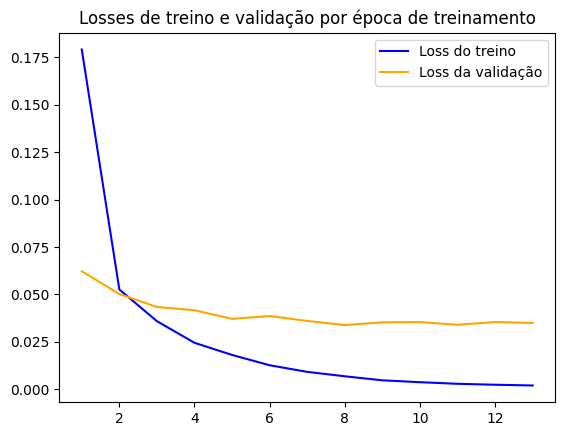

In [378]:
plot_train_val_losses(tanh_train_avg_losses, tanh_val_avg_losses)

In [379]:
model_ccn_2_tanh.test(test_loader)

/Users/mauriciosightman/Library/Python/3.9/lib/python/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0278, Accuracy: 9913/10000 (99.13%)



(0.027778208639979086, tensor(99.1300), [0.027778208639979086])

In [380]:
tanh_model_metrics = test_and_get_metrics(model_ccn_2_tanh, test_loader, device)

results.append({
    'model': 'model_ccn_2_tanh',
    'train_avg_losses': tanh_train_avg_losses,
    'val_avg_losses': tanh_val_avg_losses,
    'training_time': tanh_training_time,
    'learning_rate': learning_rate,
    'dropout_rate': dropout_rate,
    'acc':tanh_model_metrics['acc'],
    'tpr':tanh_model_metrics['tpr'],
    'precision':tanh_model_metrics['precision'],
    'f1-score':tanh_model_metrics['f1-score'],
    'y_true':tanh_model_metrics['y_true'],
    'y_pred':tanh_model_metrics['y_pred'],
    'loss':tanh_model_metrics['loss'],
})

tanh_model_metrics

{'acc': 0.9913,
 'tpr': 0.9913,
 'precision': 0.9913113914555959,
 'f1-score': 0.9912968482736348,
 'y_true': array([7, 2, 1, ..., 4, 5, 6]),
 'y_pred': array([7, 2, 1, ..., 4, 5, 6]),
 'loss': 0.0027778208739043463}

In [381]:
tanh_training_time

360.6017761230469

Quando a função de ativação foi alterada para tanh, a acurácia melhorou em 0.1 ponto percentual em comparação com o modelo anterior, e o tempo de treinamento diminuiu em 10 minutos. Isso demonstra que a escolha da função de ativação pode impactar significativamente tanto a performance quanto a eficiência do modelo.

### CNN 2 (ReLU)


In [382]:
# Define the neural network architecture
class TwoConvNNWithReLU(nn.Module):
    def __init__(self, in_features, dropout_rate=0.):
        super(TwoConvNNWithReLU, self).__init__()
        self.early_stopping = True
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=40, kernel_size=5, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.net = nn.Sequential(
          nn.Linear(40*4*4, 100),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.Linear(100, 10),
        )

    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = F.relu(self.pool2(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.net(x)
        x = nn.functional.log_softmax(x, dim=1)
        return x

    def compile(self, learning_rate, weight_decay=0.0):
      self.optimizer = optim.SGD(self.parameters(), weight_decay=weight_decay, lr=learning_rate)
      self.criterion = nn.NLLLoss()

    def fit(self, train_loader, num_epochs, val_loader = None, patience = None, delta = None):
      if val_loader is not None and patience is not None and delta is not None:
        print(f'Using early stopping with patience={patience} and delta={delta}')
        self.early_stopping = EarlyStopping(patience, delta)

      val_avg_losses = []
      train_avg_losses = []
      start_time = time.time()

      for epoch in range(num_epochs):
        # Calibrando os pesos do modelo
        train_losses = []
        self.train()
        for batch_idx, (X, y) in enumerate(train_loader):
          X, y = X.to(device), y.to(device)  # Move data to device
          output = self.forward(X)

          train_loss = self.criterion(output, y)  # Use defined criterion
          self.optimizer.zero_grad()
          train_loss.backward()
          self.optimizer.step()
          train_losses.append(train_loss.item())
        train_avg_loss = np.mean(train_losses)
        train_avg_losses.append(train_avg_loss)
        print(f'Epoch#{epoch+1}: Train Average Loss = {train_avg_loss:.5f}')

        # Mecanismo de early stopping
        if self.early_stopping is not None:
          val_losses = []
          self.eval()
          with torch.no_grad():
            for batch_idx, (X, y) in enumerate(val_loader):
              X, y = X.to(device), y.to(device)  # Move data to device
              output = self.forward(X)
              val_loss = self.criterion(output, y)
              val_losses.append(val_loss.item())
          val_avg_loss = np.mean(val_losses)
          val_avg_losses.append(val_avg_loss)
          self.early_stopping(val_avg_loss, self)
          if self.early_stopping.early_stop:
            print(f'Stopped by early stopping at epoch {epoch+1}')
            break

      if self.early_stopping is not None:
        self = torch.load('checkpoint.pt')
      self.eval()

      end_time = time.time()
      training_time = end_time - start_time
      return train_avg_losses, val_avg_losses, training_time


    def test(self, test_loader):
      test_losses = []
      test_loss = 0
      correct = 0
      with torch.no_grad():
        for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = self.forward(data)
          test_loss += F.nll_loss(output, target, size_average=False).item()
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).sum()
      test_loss /= len(test_loader.dataset)
      test_losses.append(test_loss)
      acc = 100. * correct / len(test_loader.dataset)
      print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        acc))
      return test_loss, acc, test_losses

In [386]:
input_size = train_dataset[0][0].shape[1] * train_dataset[0][0].shape[2]
learning_rate = 0.03
weight_decay = 0.001
dropout_rate = 0.
num_epochs = 60
patience = 5
delta = 0.001

In [387]:
# Create an instance of the neural network
model_ccn_2_relu = TwoConvNNWithReLU(input_size, dropout_rate).to(device)
model_ccn_2_relu.compile(learning_rate=learning_rate, weight_decay=weight_decay)

In [388]:
train_avg_losses_2_relu, val_avg_losses_2_relu, training_time_2_relu = model_ccn_2_relu.fit(train_loader, num_epochs, val_loader, patience, delta)

Using early stopping with patience=5 and delta=0.001
Epoch#1: Train Average Loss = 0.17063
Validation loss decreased (inf --> 0.05410).  Saving model ...
Epoch#2: Train Average Loss = 0.05113
Validation loss decreased (0.05410 --> 0.05074).  Saving model ...
Epoch#3: Train Average Loss = 0.03782
EarlyStopping counter: 1 out of 5. Current validation loss: 0.04994
Epoch#4: Train Average Loss = 0.03114
Validation loss decreased (0.05074 --> 0.03555).  Saving model ...
Epoch#5: Train Average Loss = 0.02649
EarlyStopping counter: 1 out of 5. Current validation loss: 0.04306
Epoch#6: Train Average Loss = 0.02406
EarlyStopping counter: 2 out of 5. Current validation loss: 0.03946
Epoch#7: Train Average Loss = 0.02252
EarlyStopping counter: 3 out of 5. Current validation loss: 0.04045
Epoch#8: Train Average Loss = 0.02086
EarlyStopping counter: 4 out of 5. Current validation loss: 0.04116
Epoch#9: Train Average Loss = 0.01918
EarlyStopping counter: 5 out of 5. Current validation loss: 0.03465


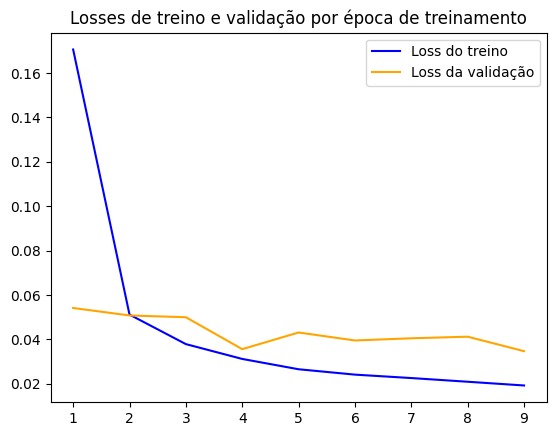

In [389]:
plot_train_val_losses(train_avg_losses_2_relu, val_avg_losses_2_relu)

In [390]:
cnn_2_metrics = test_and_get_metrics(model_ccn_2_relu, test_loader, device)

results.append({
    'model': 'model_ccn_2_relu',
    'train_avg_losses': train_avg_losses_2_relu,
    'val_avg_losses': val_avg_losses_2_relu,
    'training_time': training_time_2_relu,
    'learning_rate': learning_rate,
    'dropout_rate': dropout_rate,
    'acc':cnn_2_metrics['acc'],
    'tpr':cnn_2_metrics['tpr'],
    'precision':cnn_2_metrics['precision'],
    'f1-score':cnn_2_metrics['f1-score'],
    'y_true':cnn_2_metrics['y_true'],
    'y_pred':cnn_2_metrics['y_pred'],
    'loss':cnn_2_metrics['loss'],
})

cnn_2_metrics

{'acc': 0.99,
 'tpr': 0.99,
 'precision': 0.9900690913019445,
 'f1-score': 0.9900100762229104,
 'y_true': array([7, 2, 1, ..., 4, 5, 6]),
 'y_pred': array([7, 2, 1, ..., 4, 5, 6]),
 'loss': 0.0027317532430538903}

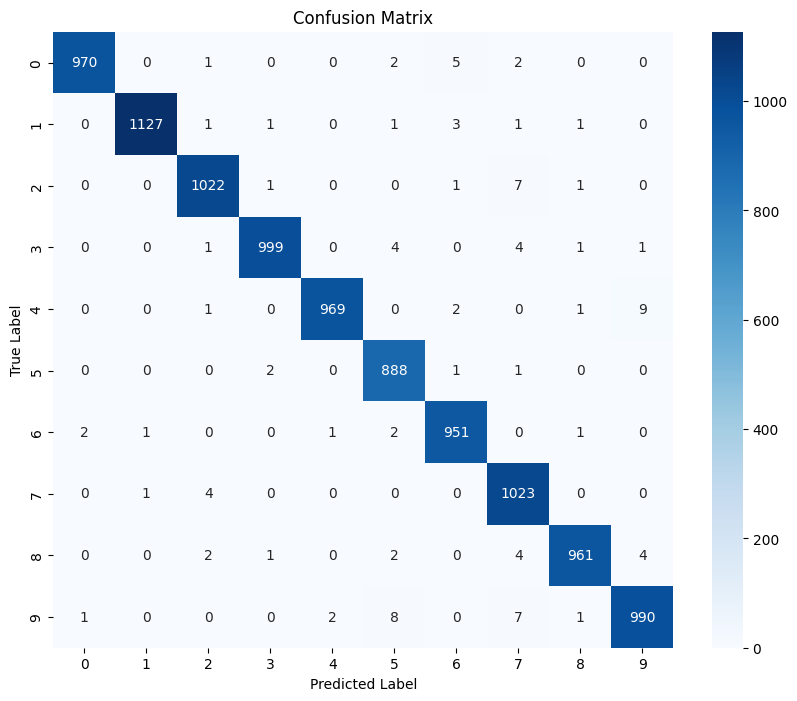

In [391]:
y_true = np.array(cnn_2_metrics['y_true'])
y_pred = np.array(cnn_2_metrics['y_pred'])

accuracy = cnn_2_metrics['acc']
precision = cnn_2_metrics['precision']
recall = cnn_2_metrics['tpr']

plot_accuracy_per_label(y_true, y_pred, output_size=10)

### Expadindo Dataset

In [295]:
# Expandindo dataset de treino
expanded_images, expanded_labels = expand_mnist_dataset(train_dataset)
expanded_train_dataset = ExpandedMNISTDataset(expanded_images, expanded_labels, transform=transform)

Expanding the MNIST training set


In [296]:
batch_size = 256

In [297]:
train_loader = torch.utils.data.DataLoader(expanded_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [298]:
print(len(train_dataset), len(expanded_train_dataset))

48000 240000


### CNN 3 (ReLU)


In [392]:
class TwoConvTwoNNWithReLU(nn.Module):
    def __init__(self, dropout_rate=0.):
        super(TwoConvTwoNNWithReLU, self).__init__()
        self.early_stopping = True
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=40, kernel_size=5, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.mlp = nn.Sequential(
          nn.Linear(40*4*4, 100),
          nn.BatchNorm1d(100),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.Linear(100, 100),
          nn.BatchNorm1d(100),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
        )
        self.fc_softmax = nn.Sequential(
          nn.Linear(100, 10),
          nn.BatchNorm1d(10)
        )

    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = F.relu(self.pool2(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.mlp(x)
        x = self.fc_softmax(x)
        x = nn.functional.log_softmax(x, dim=1)
        return x

    def compile(self, learning_rate, weight_decay=0.0):
      self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
      self.criterion = nn.NLLLoss()

    def fit(self, train_loader, num_epochs, val_loader = None, patience = None, delta = None):
      if val_loader is not None and patience is not None and delta is not None:
        print(f'Using early stopping with patience={patience} and delta={delta}')
        self.early_stopping = EarlyStopping(patience, delta)

      val_avg_losses = []
      train_avg_losses = []
      start_time = time.time()

      for epoch in range(num_epochs):
        # Calibrando os pesos do modelo
        train_losses = []
        self.train()
        for batch_idx, (X, y) in enumerate(train_loader):
          X, y = X.to(device), y.to(device)  # Move data to device
          output = self.forward(X)

          train_loss = self.criterion(output, y)  # Use defined criterion
          self.optimizer.zero_grad()
          train_loss.backward()
          self.optimizer.step()
          train_losses.append(train_loss.item())
        train_avg_loss = np.mean(train_losses)
        train_avg_losses.append(train_avg_loss)
        print(f'Epoch#{epoch+1}: Train Average Loss = {train_avg_loss:.5f}')

        # Mecanismo de early stopping
        if self.early_stopping is not None:
          val_losses = []
          self.eval()
          with torch.no_grad():
            for batch_idx, (X, y) in enumerate(val_loader):
              X, y = X.to(device), y.to(device)  # Move data to device
              output = self.forward(X)
              val_loss = self.criterion(output, y)
              val_losses.append(val_loss.item())
          val_avg_loss = np.mean(val_losses)
          val_avg_losses.append(val_avg_loss)
          self.early_stopping(val_avg_loss, self)
          if self.early_stopping.early_stop:
            print(f'Stopped by early stopping at epoch {epoch+1}')
            break

      if self.early_stopping is not None:
        self = torch.load('checkpoint.pt')
      self.eval()

      end_time = time.time()
      training_time = end_time - start_time
      return train_avg_losses, val_avg_losses, training_time


    def test(self, test_loader):
      test_losses = []
      test_loss = 0
      correct = 0
      with torch.no_grad():
        for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = self.forward(data)
          test_loss += F.nll_loss(output, target, size_average=False).item()
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).sum()
      test_loss /= len(test_loader.dataset)
      test_losses.append(test_loss)
      acc = 100. * correct / len(test_loader.dataset)
      print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        acc))
      return test_loss, acc, test_losses

In [396]:
input_size = train_dataset[0][0].shape[1] * train_dataset[0][0].shape[2]
learning_rate = 0.03
num_epochs = 60
patience = 5
delta = 0.001
dropout_rate = 0.

In [397]:
# Create an instance of the neural network
model_ccn_3_relu = TwoConvTwoNNWithReLU(dropout_rate).to(device)
model_ccn_3_relu.compile(learning_rate=learning_rate)

In [398]:
train_avg_losses_3_relu, val_avg_losses_3_relu, training_time_3_relu = model_ccn_3_relu.fit(train_loader, num_epochs, val_loader, patience, delta)

Using early stopping with patience=5 and delta=0.001
Epoch#1: Train Average Loss = 0.31439
Validation loss decreased (inf --> 0.06944).  Saving model ...
Epoch#2: Train Average Loss = 0.13740
Validation loss decreased (0.06944 --> 0.06617).  Saving model ...
Epoch#3: Train Average Loss = 0.10931
Validation loss decreased (0.06617 --> 0.05462).  Saving model ...
Epoch#4: Train Average Loss = 0.08056
Validation loss decreased (0.05462 --> 0.04157).  Saving model ...
Epoch#5: Train Average Loss = 0.06721
EarlyStopping counter: 1 out of 5. Current validation loss: 0.07221
Epoch#6: Train Average Loss = 0.06090
EarlyStopping counter: 2 out of 5. Current validation loss: 0.05681
Epoch#7: Train Average Loss = 0.05196
EarlyStopping counter: 3 out of 5. Current validation loss: 0.05532
Epoch#8: Train Average Loss = 0.04704
EarlyStopping counter: 4 out of 5. Current validation loss: 0.04976
Epoch#9: Train Average Loss = 0.04186
Validation loss decreased (0.04157 --> 0.03966).  Saving model ...
Ep

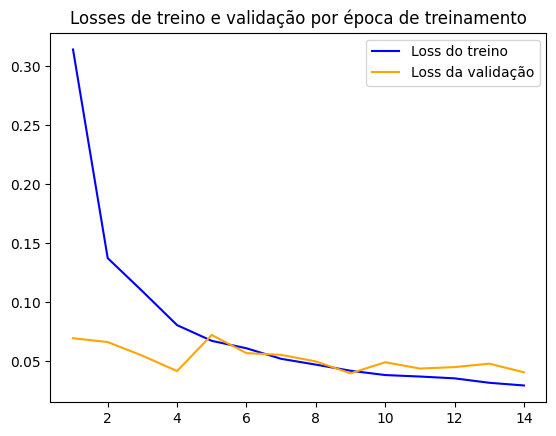

In [399]:
plot_train_val_losses(train_avg_losses_3_relu, val_avg_losses_3_relu)

In [400]:
cnn_3_metrics = test_and_get_metrics(model_ccn_3_relu, test_loader, device)

results.append({
    'model': 'model_ccn_3_relu',
    'train_avg_losses': train_avg_losses_3_relu,
    'val_avg_losses': val_avg_losses_3_relu,
    'training_time': training_time_3_relu,
    'learning_rate': learning_rate,
    'dropout_rate': dropout_rate,
    'acc':cnn_3_metrics['acc'],
    'tpr':cnn_3_metrics['tpr'],
    'precision':cnn_3_metrics['precision'],
    'f1-score':cnn_3_metrics['f1-score'],
    'y_true':cnn_3_metrics['y_true'],
    'y_pred':cnn_3_metrics['y_pred'],
    'loss':cnn_3_metrics['loss'],
})

cnn_3_metrics

{'acc': 0.9896,
 'tpr': 0.9896,
 'precision': 0.9896649746357283,
 'f1-score': 0.9896070587801477,
 'y_true': array([7, 2, 1, ..., 4, 5, 6]),
 'y_pred': array([7, 2, 1, ..., 4, 5, 6]),
 'loss': 0.0035745509097025205}

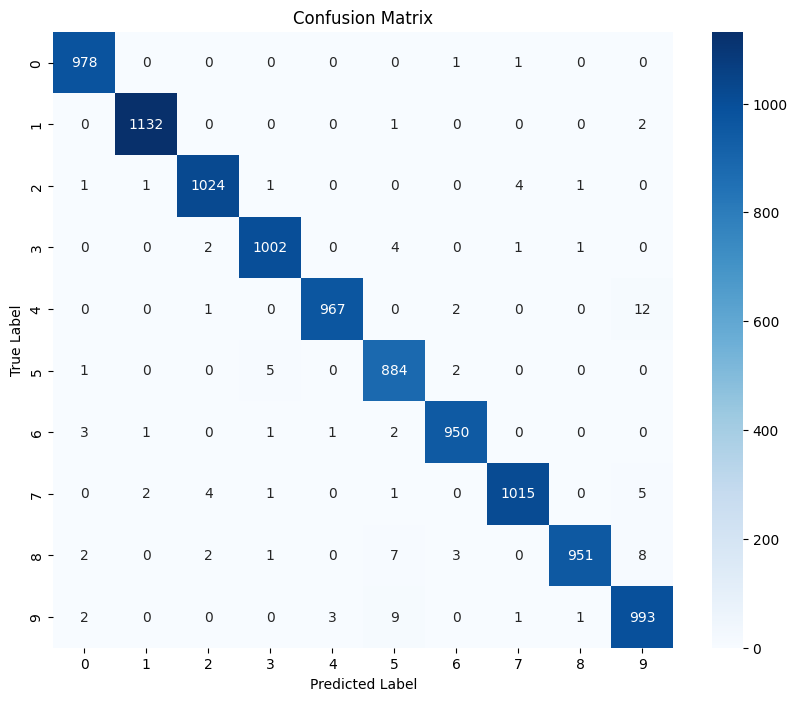

In [401]:
y_true = np.array(cnn_3_metrics['y_true'])
y_pred = np.array(cnn_3_metrics['y_pred'])

accuracy = cnn_3_metrics['acc']
precision = cnn_3_metrics['precision']
recall = cnn_3_metrics['tpr']

plot_accuracy_per_label(y_true, y_pred, output_size=10)

In [402]:
training_time_3_relu

479.27935695648193

Finalmente, ao adicionar mais uma camada MLP, a acurácia aumentou em 0.14 ponto percentual, mas o tempo de treinamento também aumentou para 18 minutos. Isso mostra que, embora a adição de camadas possa melhorar a precisão, ela também pode resultar em um tempo de treinamento significativamente maior, enfatizando novamente o trade-off entre a precisão e a eficiência do modelo.

#### Camparativos


In [403]:
df_results = pd.DataFrame(results)

In [404]:
df_results.to_csv('results.csv', index=False)

In [405]:
df_results.head(10)

,model,train_avg_losses,val_avg_losses,training_time,learning_rate,dropout_rate,acc,tpr,precision,f1-score,y_true,y_pred,loss
0,mlp_model,"[2.0052432303733014, 1.3290793730857524, 0.915...","[1.6568751994599686, 1.0792952179908752, 0.799...",290.080246,0.0300,0.0,0.9397,0.9397,0.939691,0.939570,"[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, ...","[7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, ...",0.000829
1,model_ccn_1,"[2.2763319687640413, 2.1690899869228932, 1.822...","[2.244567450056685, 2.0573253327227654, 1.5535...",636.677289,0.0300,0.0,0.9504,0.9504,0.950585,0.950335,"[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, ...","[7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, ...",0.000687
2,model_ccn_2,"[2.3034208011119923, 2.3011076526438936, 2.300...","[2.302575654171883, 2.302462248092002, 2.30212...",1232.541428,0.0300,0.0,0.9528,0.9528,0.952862,0.952748,"[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, ...","[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, ...",0.000623
3,model_ccn_2_tanh,"[1.2570741011741313, 0.400661309348776, 0.2673...","[0.5448184958163728, 0.3192044642377407, 0.237...",1584.553170,0.0300,0.0,0.9890,0.9890,0.989009,0.988995,"[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, ...","[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, ...",0.000128
4,model_ccn_2_relu,"[2.3130850715840117, 2.3036965461487466, 2.295...","[2.30612084713388, 2.2977310190809535, 2.28999...",1567.725684,0.0005,0.0,0.8982,0.8982,0.897925,0.897891,"[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, ...","[7, 2, 1, 0, 4, 1, 4, 9, 2, 9, 0, 6, 9, 0, 1, ...",0.001390
5,model_ccn_2_relu,"[0.29220656094266406, 0.10401512350418421, 0.0...","[1.223096122132971, 0.43032390323091063, 0.314...",4878.394298,0.0005,0.0,0.9195,0.9195,0.933971,0.920112,"[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, ...","[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, ...",0.001185
6,model_ccn_3_relu,"[0.29220656094266406, 0.10401512350418421, 0.0...","[1.223096122132971, 0.43032390323091063, 0.314...",4878.394298,0.0005,0.0,0.9195,0.9195,0.933971,0.920112,"[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, ...","[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, ...",0.001185
7,mlp_model,"[0.5366471463888107, 0.27761141340267687, 0.22...","[0.3052345858033126, 0.2459034265523466, 0.224...",506.316585,0.0300,0.0,0.9784,0.9784,0.978411,0.978397,"[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, ...","[7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, ...",0.007186
8,model_ccn_1,"[0.1340724692882456, 0.11033780303793415, 0.09...","[0.12184174619110612, 0.10504414254974108, 0.0...",502.469716,0.0300,0.0,0.9865,0.9865,0.986550,0.986502,"[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, ...","[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, ...",0.004126
9,model_ccn_2,"[1.961160781107222, 0.3493140129219197, 0.1770...","[0.6376968122770389, 0.21321535075626646, 0.14...",720.113255,0.0300,0.0,0.9890,0.9890,0.989030,0.988999,"[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, ...","[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, ...",0.003027


In [406]:
df_results['training_time'] = df_results['training_time'] / 60

In [407]:
idx = df_results.groupby('model')['acc'].idxmax()
df_best_models = df_results.loc[idx].sort_values(by='acc', ascending=False)

In [408]:
df_best_models[['model', 'training_time', 'learning_rate', 'dropout_rate', 'precision', 'loss']]

,model,training_time,learning_rate,dropout_rate,precision,loss
10,model_ccn_2_tanh,6.010030,0.03,0.0,0.991311,0.002778
11,model_ccn_2_relu,3.621776,0.03,0.0,0.990069,0.002732
12,model_ccn_3_relu,7.987989,0.03,0.0,0.989665,0.003575
9,model_ccn_2,12.001888,0.03,0.0,0.989030,0.003027
8,model_ccn_1,8.374495,0.03,0.0,0.986550,0.004126
7,mlp_model,8.438610,0.03,0.0,0.978411,0.007186


/var/folders/fs/f8qz96w55l1cqqbyb70x11380000gn/T/ipykernel_89513/958463046.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='model', y='acc', data=df_best_models, palette='viridis')


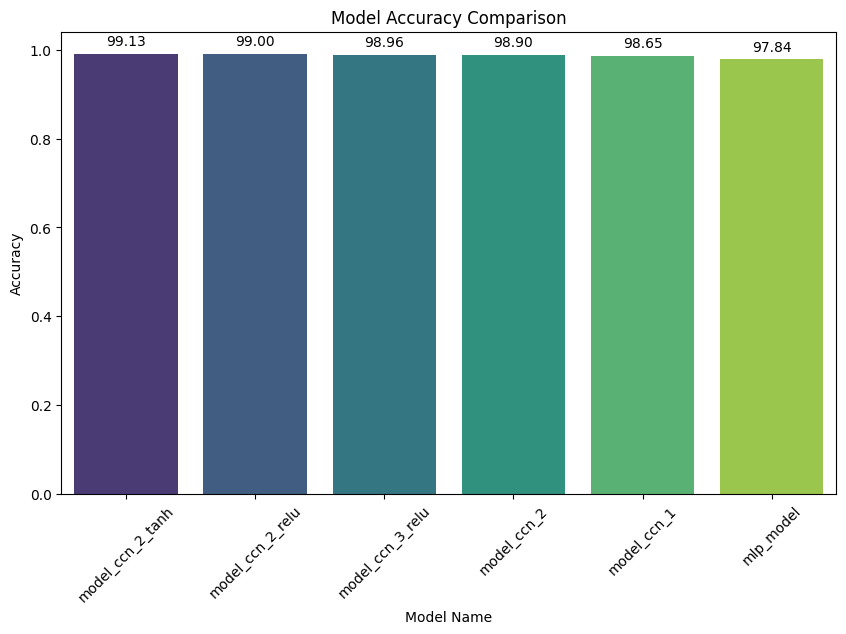

In [409]:
# Create the bar chart with seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='model', y='acc', data=df_best_models, palette='viridis')

# Add titles and labels
plt.xlabel('Model Name')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')

plt.xticks(rotation=45)

# Add accuracy values on top of the bars
for p in ax.patches:
    ax.annotate(f'{(p.get_height()*100):.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')

# Show the plot
plt.show()

O gráfico mostra a maior acurácia de cada arquitetura criada. O modelo com a função de ativação Tanh se destacou.

/var/folders/fs/f8qz96w55l1cqqbyb70x11380000gn/T/ipykernel_89513/1056795789.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='model', y='acc', data=df_results, palette='viridis')


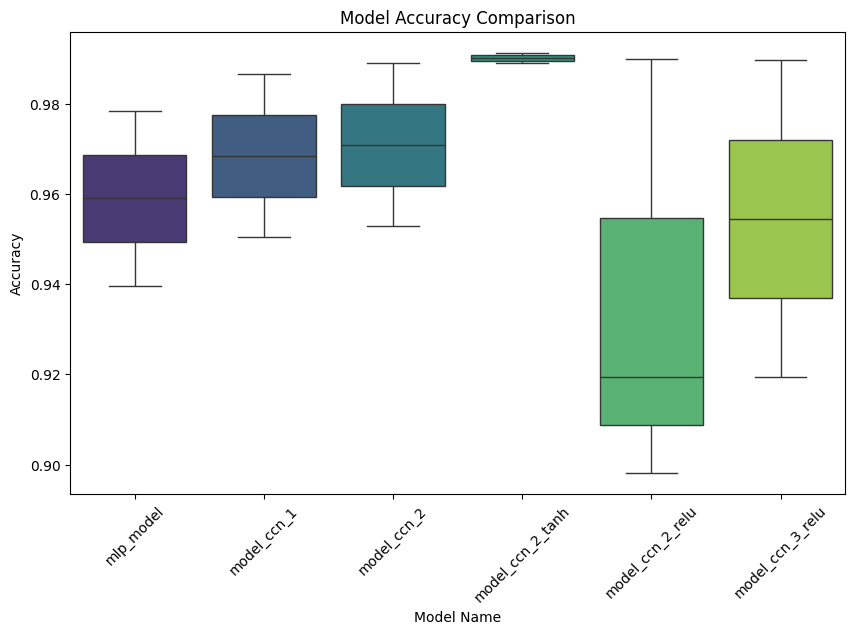

In [414]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='model', y='acc', data=df_results, palette='viridis')

plt.xlabel('Model Name')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')

plt.xticks(rotation=45)

plt.show()

Entre a média dos testes de cada modelo, ainda o Tanh se mostrou sempre se adaptar bem aos dados.

/var/folders/fs/f8qz96w55l1cqqbyb70x11380000gn/T/ipykernel_89513/3003280060.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='model', y='training_time', data=df_results, palette='viridis')


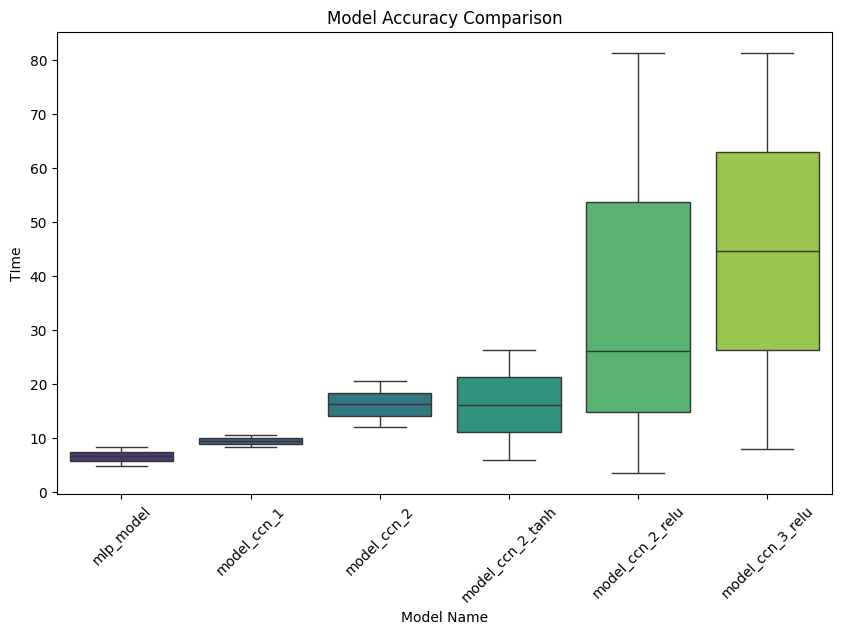

In [412]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='model', y='training_time', data=df_results, palette='viridis')

plt.xlabel('Model Name')
plt.ylabel('TIme')
plt.title('Model Accuracy Comparison')

plt.xticks(rotation=45)

plt.show()

Com relação ao tempo de treinamento, como previsto quanto maior a arquitetura maior o tempo necessário.